In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle  # or use numpy if .npy
from pathlib import Path
plt.rcParams.update({'font.size': 15})

# Fig 1

In [ ]:
import numpy as np
from pathlib import Path

# Directory path
fig1_dir = Path("Fig 1")

# Get all CSV files in the directory
csv_files = list(fig1_dir.glob("*.csv"))

# Check we have exactly two CSV files
if len(csv_files) != 2:
    raise ValueError(f"Expected exactly 2 CSV files in {fig1_dir}, found {len(csv_files)}")

# Load and assign
for file in csv_files:
    data = np.loadtxt(file, delimiter=",")
    if "low" in file.name.lower():
        low = data
        print(f"Loaded '{file.name}' into variable 'low'")
    else:
        high = data
        print(f"Loaded '{file.name}' into variable 'high'")


Loaded '4q_low_power.csv' into variable 'low'
Loaded '4q_high_power.csv' into variable 'high'


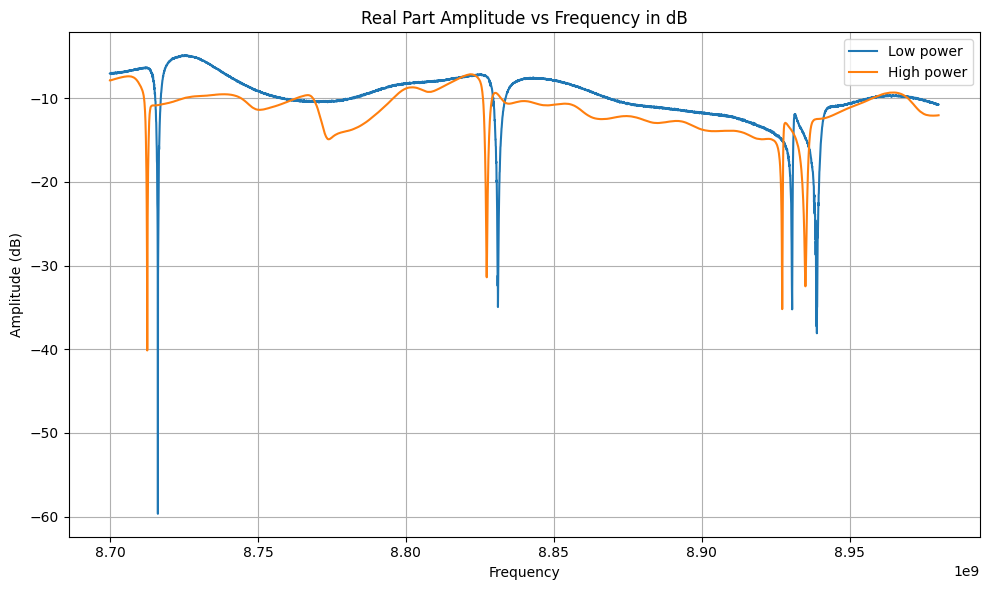

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

freq = low[:, 0]
amplitude_part = low[:, 1]
amplitude_part_high_power_readout = high[:, 1]

# Convert to dB (handle zero or negative values safely by adding a tiny epsilon)
epsilon = 1e-12
amp_low_db = 20 * np.log10(np.abs(amplitude_part) + epsilon)
amp_high_db = 20 * np.log10(np.abs(amplitude_part_high_power_readout) + epsilon)

plt.figure(figsize=(10, 6))
plt.plot(freq, amp_low_db, label='Low power')
plt.plot(freq, amp_high_db, label='High power')

plt.xlabel('Frequency')
plt.ylabel('Amplitude (dB)')
plt.title('Real Part Amplitude vs Frequency in dB')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Fig 2

For simplicity, uncorrected infidelities are called saddata, corrected infidelities are called data

In [184]:
# Define the base path
base_path = os.path.join("fig 2", "the big Fig 2 database")

# Get all subdirectories and sort them
subdirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
subdirs.sort()  # Sort alphabetically

# Initialize the data lists
data = []
saddata = []

# Load the two arrays from each sorted subdirectory's .npy file
for folder in subdirs:
    qst_path = os.path.join(base_path, folder, "QST_results.npy")
    if os.path.exists(qst_path):
        with open(qst_path, "rb") as f:
            try:
                corrected = np.load(f, allow_pickle=True)
                raw = np.load(f, allow_pickle=True)
                data.append(corrected)
                saddata.append(raw)
            except Exception as e:
                print(f"Error reading from {qst_path}: {e}")
    else:
        print(f"Warning: 'QST_results.npy' not found in {folder}")


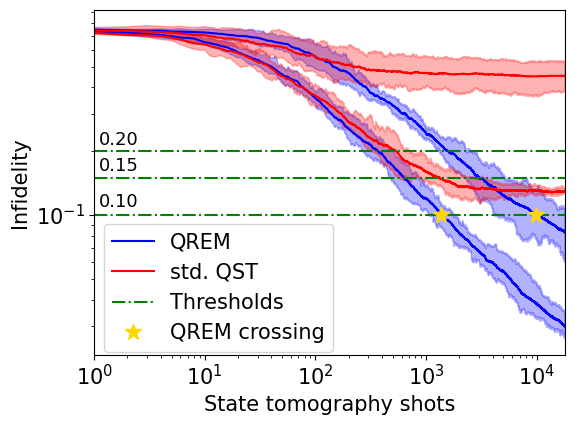

In [185]:

# Assuming 'data' and 'saddata' are already defined and populated

plt.figure(figsize=(6, 4.5))
#print(data)
plt.plot(data[4].mean(axis=0),color = 'blue' ,  label="QREM")
#plt.plot(data[3].mean(axis=0), color = 'blue')
plt.plot(data[2].mean(axis=0), color = 'blue')


sorted_data_2 = np.array([np.sort(data[2][:,row_index]) for row_index in range(len(data[2][0]))])
plt.fill_between(np.arange(len(sorted_data_2)), sorted_data_2.T[3], sorted_data_2.T[-3], color="blue", alpha=0.3)

sorted_data_4 = np.array([np.sort(data[4][:,row_index]) for row_index in range(len(data[4][0]))])
plt.fill_between(np.arange(len(sorted_data_4)), sorted_data_4.T[3], sorted_data_4.T[-3], color="blue", alpha=0.3)

plt.plot(saddata[4].mean(axis=0), color='red', label="std. QST")
plt.plot(saddata[2].mean(axis=0), color='red')

sorted_saddata_2 = np.array([np.sort(saddata[2][:,row_index]) for row_index in range(len(saddata[2][0]))])
plt.fill_between(np.arange(len(sorted_saddata_2)), sorted_saddata_2.T[3], sorted_saddata_2.T[-3], color="red", alpha=0.3)

sorted_saddata_4 = np.array([np.sort(saddata[4][:,row_index]) for row_index in range(len(saddata[4][0]))])
plt.fill_between(np.arange(len(sorted_saddata_4)), sorted_saddata_4.T[3], sorted_saddata_4.T[-3], color="red", alpha=0.3)

# Add thicc horizontal reference lines
for y in [0.1, 0.15, 0.2]:
    plt.axhline(y=y, color='green', linestyle='-.', linewidth=1.5, label="Thresholds" if y == 0.2 else "")  # <-- thicker lines
    plt.text(0.01, y + 0.005, f"{y:.2f}", va='bottom', ha='left',
             transform=plt.gca().get_yaxis_transform(), fontsize=13)



# Detect threshold crossings for mean4 and mean2
threshold = 0.1

crossings4 = np.where(np.diff(np.sign(data[4].mean(axis=0) - threshold)) != 0)[0]
crossings2 = np.where(np.diff(np.sign(data[2].mean(axis=0) - threshold)) != 0)[0]


if len(crossings4) > 0:
    idx4 = crossings4[0]
    plt.plot(idx4, data[4].mean(axis=0)[idx4], '*', color='gold', markersize=12, label="QREM crossing")

if len(crossings2) > 0:
    idx2 = crossings2[0]
    plt.plot(idx2, data[2].mean(axis=0)[idx2], '*', color='gold', markersize=12)


plt.legend(bbox_to_anchor=(0.53, 0.41))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("State tomography shots")
plt.ylabel("Infidelity")
plt.xlim(left=1, right=len(data[4].mean(axis=0)))
#plt.title("Mean QST Results Across Settings")
#plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.savefig("fig_2.pdf", bbox_inches='tight')
plt.show()


# Fig 3

In [199]:
ro_powers= np.linspace(0.2, 0.7, 12)

# Path to the target folder
target_dir = Path("fig 3/readout thresholding vs power")

# Create a dictionary to store the variables
data_vars = {}

# Loop over all .npy files in the directory
for npy_file in target_dir.glob("*.npy"):
    var_name = npy_file.stem  # file name without extension
    try:
        array = np.load(npy_file, allow_pickle=False)
        data_vars[var_name] = array
        print(f"Loaded '{var_name}' from {npy_file.name}")
    except Exception as e:
        print(f"Failed to load {npy_file.name}: {e}")
for var_name, array in data_vars.items():
    globals()[var_name] = array

Loaded 'assignment_fidelities_0' from assignment_fidelities_0.npy
Loaded 'assignment_fidelities_1' from assignment_fidelities_1.npy
Loaded 'averaged_infidelity_list_vs_ro_power' from averaged_infidelity_list_vs_ro_power.npy
Loaded 'err010s_ro' from err010s_ro.npy
Loaded 'err015s_ro' from err015s_ro.npy
Loaded 'err020s_ro' from err020s_ro.npy
Loaded 'list010s_ro' from list010s_ro.npy
Loaded 'list015s_ro' from list015s_ro.npy
Loaded 'list020s_ro' from list020s_ro.npy
Loaded 'positions_0_10s' from positions_0_10s.npy
Loaded 'positions_0_15s' from positions_0_15s.npy
Loaded 'positions_0_20s' from positions_0_20s.npy
Loaded 'std_variance_list_vs_ro_power' from std_variance_list_vs_ro_power.npy


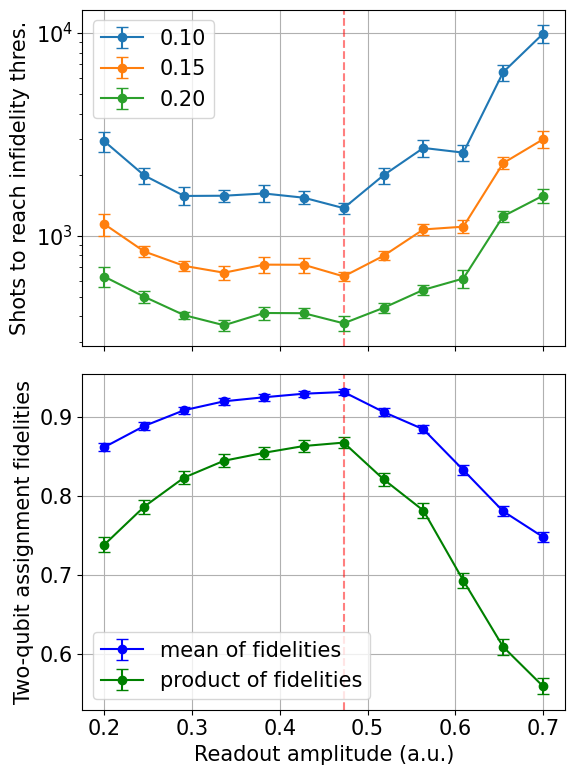

In [200]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
manual_optim_index = 6  # Index of the manual optimization point
# --- Top plot ---
ax1.axvline(x=ro_powers[manual_optim_index], color='r', linestyle='--', alpha=0.5)
ax1.errorbar(ro_powers, positions_0_10s, yerr=err010s_ro, label="0.10", fmt='o-',capsize=4)
ax1.errorbar(ro_powers, positions_0_15s, yerr=err015s_ro, label="0.15", fmt='o-',capsize=4)
ax1.errorbar(ro_powers, positions_0_20s, yerr=err020s_ro, label="0.20", fmt='o-',capsize=4)

ax1.set_yscale("log")
ax1.set_ylabel("Shots to reach infidelity thres.")
#ax1.set_title("Position vs Readout Power with Vertical Error Bars")
ax1.grid(True)
ax1.legend()

# Computing the standard deviation for assignment fidelities
N = 2000 # The number of shots used to estimate probabilities
var_mean = 0.5**2*(assignment_fidelities_0*(1-assignment_fidelities_0)/N + assignment_fidelities_1*(1-assignment_fidelities_1)/N)
var_product = (assignment_fidelities_0*(1-assignment_fidelities_0) * assignment_fidelities_1*(1-assignment_fidelities_1)/N**2
                + (assignment_fidelities_0**2 *assignment_fidelities_1* (1-assignment_fidelities_1) )/ N
                + (assignment_fidelities_1**2 * assignment_fidelities_0*(1-assignment_fidelities_0) )/ N)

# --- Bottom plot ---
ax2.errorbar(ro_powers, 0.5 * (assignment_fidelities_0 + assignment_fidelities_1),  yerr=np.sqrt(var_mean),
         label="mean of fidelities",fmt='o-', color= "b", capsize=4)
#ax2.errorbar(rho_powers, )
ax2.errorbar(ro_powers, assignment_fidelities_0 * assignment_fidelities_1, yerr=np.sqrt(var_product),
         label="product of fidelities",fmt='o-', color= "g", capsize=4)
ax2.axvline(x=ro_powers[manual_optim_index], color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel("Readout amplitude (a.u.)")
ax2.set_ylabel("Two-qubit assignment fidelities")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

fig.savefig("fig_3.pdf", bbox_inches='tight')


# Fig 4

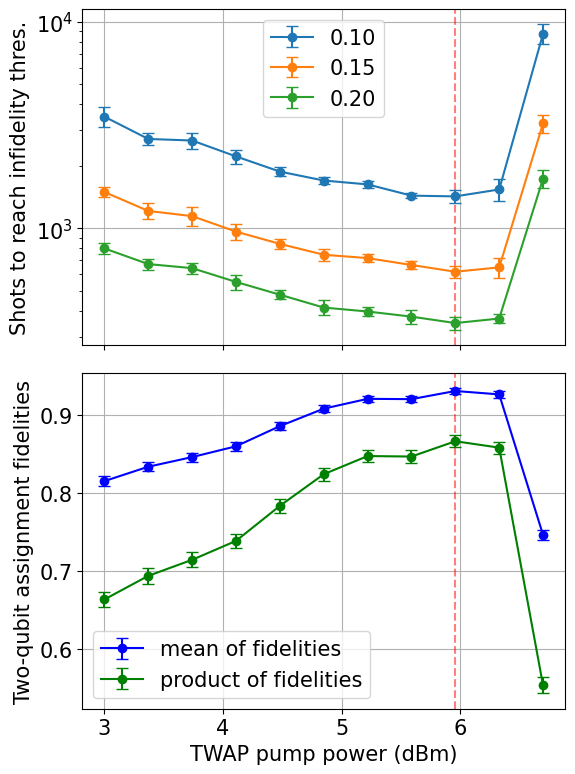

In [189]:

# Path to the directory with the .npy files
data_dir = "fig 4/inf v twpa v2"

# Read all .npy files and assign to variables based on filename
for filename in os.listdir(data_dir):
    if filename.endswith(".npy"):
        var_name = filename[:-4]  # Remove .npy extension
        file_path = os.path.join(data_dir, filename)
        globals()[var_name] = np.load(file_path)

# Create the TWPA power array
twpa_powers = np.linspace(3, 6.7, 11)

manual_optim_index = 8

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# --- Top plot ---
ax1.axvline(x=twpa_powers[manual_optim_index], color='r', linestyle='--', alpha=0.5)
ax1.errorbar(twpa_powers, list010s_ro, yerr=err010s_ro, fmt='o-', capsize=4, label='0.10')
ax1.errorbar(twpa_powers, list015s_ro, yerr=err015s_ro, fmt='o-', capsize=4, label='0.15')
ax1.errorbar(twpa_powers, list020s_ro, yerr=err020s_ro, fmt='o-', capsize=4, label='0.20')

ax1.set_yscale("log")
ax1.set_ylabel("Shots to reach infidelity thres.")
#ax1.set_title("Position vs Readout Power with Vertical Error Bars")
ax1.grid(True)
ax1.legend()



# Load assignment fidelity arrays
f0 = assignment_fidelities_0
f1 = assignment_fidelities_1

# Compute mean and product
mean_fidelity = (f0 + f1) / 2
product_fidelity = f0 * f1



# Computing the standard deviation for assignment fidelities
N = 2000 # The number of shots used to estimate probabilities
var_mean = 0.5**2*(assignment_fidelities_0*(1-assignment_fidelities_0)/N + assignment_fidelities_1*(1-assignment_fidelities_1)/N)
var_product = (assignment_fidelities_0*(1-assignment_fidelities_0) * assignment_fidelities_1*(1-assignment_fidelities_1)/N**2
                + (assignment_fidelities_0**2 *assignment_fidelities_1* (1-assignment_fidelities_1) )/ N
                + (assignment_fidelities_1**2 * assignment_fidelities_0*(1-assignment_fidelities_0) )/ N)

# --- Bottom plot ---
ax2.errorbar(twpa_powers, 0.5 * (assignment_fidelities_0 + assignment_fidelities_1),  yerr=np.sqrt(var_mean),
         label="mean of fidelities",fmt='o-', color= "b", capsize=4)
#ax2.errorbar(rho_powers, )
ax2.errorbar(twpa_powers, assignment_fidelities_0 * assignment_fidelities_1, yerr=np.sqrt(var_product),
         label="product of fidelities",fmt='o-', color= "g", capsize=4)
ax2.axvline(x=twpa_powers[manual_optim_index], color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel("TWAP pump power (dBm)")
ax2.set_ylabel("Two-qubit assignment fidelities")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


fig.savefig("fig_4.pdf", bbox_inches='tight')

# Fig 5

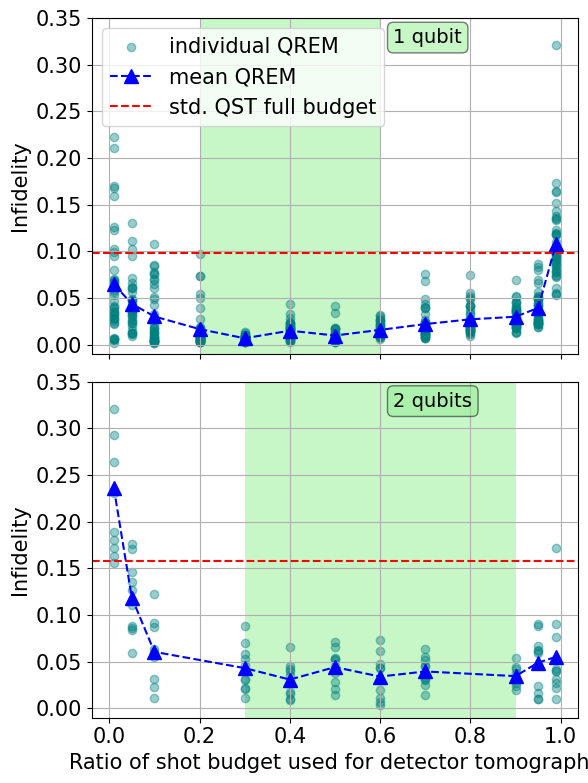

In [201]:
import matplotlib.patches as patches
# Define path


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

ax_list = [ax1, ax2]
limit_array = [0.2,0.3]
span_array = [0.4,0.6]
labels = ['1 qubit', '2 qubits']
for j, ax in enumerate(ax_list):
    dir = f"fig 5/1 and 2 qubit shot budgeting/{j+1}"
    scatters_dir = os.path.join(dir, "scatters")

    # Load arrays from directory 1
    dt_ratios_1 = np.load(f"{dir}/dt_ratios.npy")
    last_corr_inf_1 = np.load(f"{dir}/last_corr_inf.npy")
    last_uncorr_inf_1 = np.load(f"{dir}/last_uncorr_inf.npy")

    # Get and sort subfolders inside 'scatters'
    subfolders = sorted([
        f for f in os.listdir(scatters_dir)
        if os.path.isdir(os.path.join(scatters_dir, f))
    ])

    # Load QST_results.npy into infidelities list
    infidelities = []
    for subfolder in subfolders:
        file_path = os.path.join(scatters_dir, subfolder, "QST_results.npy")
        if os.path.isfile(file_path):
            try:
                data = np.load(file_path, allow_pickle=True)
                infidelities.append(np.array(data))
            except Exception as e:
                print(f"Failed to load {file_path}: {e}")
        else:
            print(f"File not found: {file_path}")

    solid_box = patches.Rectangle((limit_array[j], -.02), span_array[j], 0.5, facecolor='lightgreen', alpha=0.5)
    ax.add_patch(solid_box)

# Plot the main lines#

#ax1.plot(dt_ratios_1, last_uncorr_inf_1, label='Uncorrelated Info (1)', marker='^')

# Add scatter points from infidelities
    for i, dt in enumerate(dt_ratios_1):
        if i < len(infidelities):
            try:
                y_vals = infidelities[i].T[-1]  # last row after transpose
                x_vals = np.full_like(y_vals, dt)
                ax.scatter(x_vals, y_vals, alpha=0.4, label=f'individual QREM' if i == 0 else "", color='teal')
            except Exception as e:
                print(f"Failed to process infidelities[{i}]: {e}")

    ax.plot(dt_ratios_1, last_corr_inf_1, label='mean QREM', linestyle='--', marker='^', color='blue', markersize=10)
    ax.axhline(y=last_uncorr_inf_1[0], color='red', linestyle='--', label='std. QST full budget')
    textstr = f"{labels[j]}"
    props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)

    ax.text(0.62, 0.97, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    ax.set_ylim(-0.01, 0.35)
    ax.grid(True)
    ax.set_ylabel('Infidelity')
    

ax2.set_xlabel('Ratio of shot budget used for detector tomography')

ax1.legend(loc=2)
fig.tight_layout()



fig.savefig("fig_5.pdf", bbox_inches='tight')


# Fig 6

In [226]:
# Base directory
base_dir = Path("fig 6/3q for 6 shot numbers/2/2024-08-19_16-40-18_c8d566f4-d928-40de-8100-352cc20eab58")

result = np.load(base_dir / "QST_settings.npy", allow_pickle=True).item()
outcomes = result['outcome_index']
print(6**3)
print(len(outcomes[0])/216)

216
50.0


In [191]:


# Base directory
base_dir = Path("fig 6/3q for 6 shot numbers")

# Dictionary to hold all results
all_results = {}
all_results2 = {}

# Loop over folders named "1" through "6"
for i in range(1, 7):
    folder_path = base_dir / str(i)
    
    # Find the folder starting with "2024"
    year_folder = next((f for f in folder_path.iterdir() if f.is_dir() and f.name.startswith("2024")), None)
    
    if year_folder is None:
        print(f"No 2024 folder found in {folder_path}")
        continue

    # Path to QST_results file
    qst_path = year_folder / "QST_results.npy"  # or "QST_results.npy"

    if not qst_path.exists():
        print(f"QST_results file not found in {year_folder}")
        continue

    # Load the data
    with open(qst_path, "rb") as f:
        qst_data = np.load(f) #corrected infidelities
        qst_data2 = np.load(f) #raw uncorrected infidelities
    
    # Store in dictionary
    all_results[str(i)] = qst_data
    all_results2[str(i)] = qst_data2
# Now all_results contains QST_results from folders "1" through "6"
print("Loaded QST_results from folders:", list(all_results.keys()))


Loaded QST_results from folders: ['1', '2', '3', '4', '5', '6']


In [192]:
shot_numbers = np.sort([3e3,4e2, 1e2, 6e3, 1e3, 12e3])
inf =np.zeros([6])
inf[0] = all_results["1"][0][-1]
inf[1] = all_results["2"][0][-1]
inf[2]= all_results["3"][0][-1]

inf[3]= all_results["4"][0][-1]
inf[4]= all_results["5"][0][-1]
inf[5]= all_results["6"][0][-1]

inf2 =np.zeros([6])
inf2[0] = all_results2["1"][0][-1]
inf2[1] = all_results2["2"][0][-1]
inf2[2]= all_results2["3"][0][-1]

inf2[3]= all_results2["4"][0][-1]
inf2[4]= all_results2["5"][0][-1]
inf2[5]= all_results2["6"][0][-1]

print(all_results['1'])

[[0.         0.         0.         ... 0.         0.         0.01422509]]


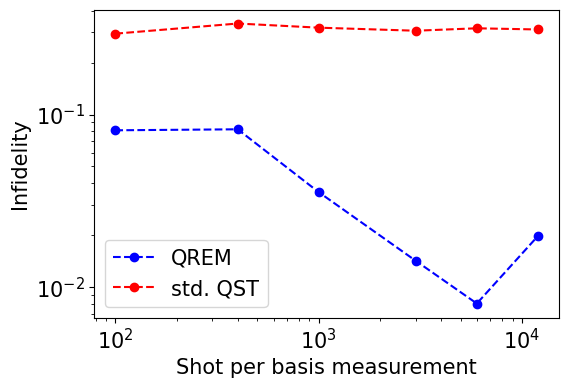

In [193]:
plt.figure(figsize=(6, 4))
plt.plot(shot_numbers, inf[[2,1,4,0,3,5]], 'o--', label="QREM", color='blue')
plt.plot(shot_numbers, inf2[[2,1,4,0,3,5]], 'o--', label="std. QST", color='red')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Shot per basis measurement")
plt.ylabel("Infidelity")
plt.legend()
plt.savefig("fig_6.pdf", bbox_inches='tight')

# Fig 7

## Generating uncorrelated POVM data

In [17]:
from EMQST_lib.povm import POVM
from EMQST_lib import dt
from EMQST_lib import support_functions as sf
# Simulating uncorrelated POVM sample fluctuations
n_qubits = 2
n_averages = 100
calib_states = sf.get_calibration_states(n_qubits, "SIC")[0]
num_calib_states = len(calib_states)
shot_range = np.array([50, 100, 400, 800, 1200, 2500, 4000, 8000, 12000, 20000, 30000, 50000, 70000])//num_calib_states


print(shot_range)
true_povm = POVM.generate_computational_POVM(n_qubits)

total_quantum_array = []
total_classical_array = []
for average in range(n_averages):
    quantum_corr_array = []
    classical_corr_array = []
    for n_shots in shot_range:
        return_povm = dt.device_tomography(n_qubits,n_shots,true_povm, calib_states)

        classical_corr_coeff = np.array([povm.get_classical_correlation_coefficient() for povm in return_povm])
        classical_corr_array.append(classical_corr_coeff.mean())

        quantum_corr_coeff = np.array([povm.get_quantum_correlation_coefficient() for povm in return_povm])
        quantum_corr_array.append(quantum_corr_coeff.mean())
    total_quantum_array.append(quantum_corr_array)
    total_classical_array.append(classical_corr_array)


np.save('fig 7/uncorrelated_quantum_array.npy',np.array(total_quantum_array))
np.save('fig 7/uncorrelated_classical_array.npy',np.array(total_classical_array))




[   3    6   25   50   75  156  250  500  750 1250 1875 3125 4375]
Done collecting and sorting QDT data, total runtime 0.0.
Starting POVM reconstruction.
	Number of MLE iterations: 350, final distance 2.33294855656041e-10
Runtime of parallel POVM reconstruction 0.15144610404968262
Done collecting and sorting QDT data, total runtime 0.0.
Starting POVM reconstruction.
	Number of MLE iterations: 100, final distance 2.5269834835750515e-11
Runtime of parallel POVM reconstruction 0.05488872528076172
Done collecting and sorting QDT data, total runtime 0.0.
Starting POVM reconstruction.
	Number of MLE iterations: 150, final distance 1.753763106959738e-11
Runtime of parallel POVM reconstruction 0.07155632972717285
Done collecting and sorting QDT data, total runtime 0.0.
Starting POVM reconstruction.
	Number of MLE iterations: 1350, final distance 3.7581874418046723e-10
Runtime of parallel POVM reconstruction 0.4951791763305664
Done collecting and sorting QDT data, total runtime 0.0.
Starting PO

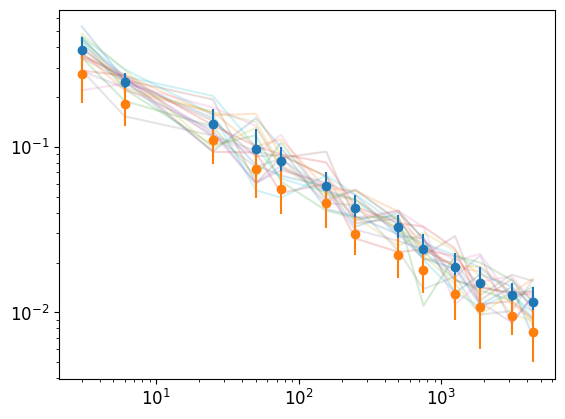

In [123]:
for i, corr_array in enumerate(total_quantum_array):
    plt.plot(shot_range, corr_array, label=f"Average {i+1}", alpha=0.2)

plt.errorbar(shot_range, np.mean(total_quantum_array, axis=0), yerr=np.std(total_quantum_array, axis=0), label="Mean ± STD", fmt="o")
plt.errorbar(shot_range, np.mean(total_classical_array, axis=0), yerr=np.std(total_classical_array, axis=0), label="Mean ± STD", fmt="o")
plt.yscale("log")
plt.xscale("log")

## Plotting

In [3]:
# Load uncorrealted simulated data
total_quantum_array = np.load('fig 7/uncorrelated_quantum_array.npy')
total_classical_array = np.load('fig 7/uncorrelated_classical_array.npy')
# Target directory
fig7a_dir = "fig 7/fig 7/A/"

# Dictionary to store loaded arrays
dataA = {}

# Load all .npy files
for file in os.listdir(fig7a_dir):
    if file.endswith('.npy'):
        key = file[:-4]  # Remove '.npy'
        file_path = os.path.join(fig7a_dir, file)
        try:
            arr = np.load(file_path, allow_pickle=True)
            # Ensure we store clean ndarray (not object array)
            if isinstance(arr, np.ndarray) and arr.dtype == object:
                try:
                    arr = np.stack(arr)
                except Exception:
                    arr = np.array(arr)
            dataA[key] = arr
        except Exception as e:
            print(f"Failed to load {file}: {e}")



# Target directory
fig7a_dir = "fig 7/fig 7/C/"

# Dictionary to store loaded arrays
dataC = {}

# Load all .npy files
for file in os.listdir(fig7a_dir):
    if file.endswith('.npy'):
        key = file[:-4]  # Remove '.npy'
        file_path = os.path.join(fig7a_dir, file)
        try:
            arr = np.load(file_path, allow_pickle=True)
            # Ensure we store clean ndarray (not object array)
            if isinstance(arr, np.ndarray) and arr.dtype == object:
                try:
                    arr = np.stack(arr)
                except Exception:
                    arr = np.array(arr)
            dataC[key] = arr
        except Exception as e:
            print(f"Failed to load {file}: {e}")

dt_shot_list_C = [50, 100, 400, 800, 1200, 2500, 4000, 8000, 12000, 20000, 30000, 50000, 70000]

dt_shot_list_A = [50, 100, 400, 800, 1200, 3000, 5000, 10000, 20000, 30000, 50000, 70000]

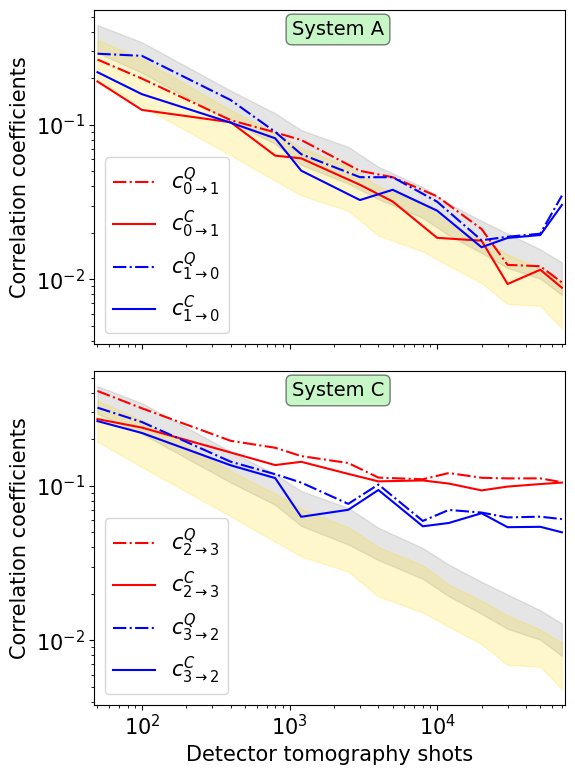

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

ax1.plot(dt_shot_list_A, dataA["quantum_corr_01s"], label = r'$c_{0\rightarrow 1}^Q$',color = 'red', linestyle='-.') 
ax1.plot(dt_shot_list_A, dataA["classical_corr_01s"], label = r'$c_{0\rightarrow 1}^C$', color='red')

ax1.plot(dt_shot_list_A, dataA["quantum_corr_10s"],  label = r'$c_{1\rightarrow 0}^Q$', color='blue', linestyle='-.')
ax1.plot(dt_shot_list_A, dataA["classical_corr_10s"], label = r'$c_{1\rightarrow 0}^C$', color='blue')

textstr = f"System A"
props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)

ax1.text(0.42, 0.97, textstr, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel("Correlation coefficients")

#ax1.set_title("system A")
ax1.legend()

#ax2.errorbar(dt_shot_list_C, np.mean(total_quantum_array, axis=0), yerr=np.std(total_quantum_array, axis=0),
#             label="Uncorrelated quantum Mean ± STD", fmt="o", capsize=4, linestyle='--')
#ax2.errorbar(dt_shot_list_C, np.mean(total_classical_array, axis=0), yerr=np.std(total_classical_array, axis=0),
#             label="Uncorrelated classical Mean ± STD", fmt="o", capsize=4, linestyle='--')

# Plot mean lines
#ax2.plot(dt_shot_list_C, np.mean(total_quantum_array, axis=0), label="Uncorrelated quantum", color="purple", linestyle = '--')
#ax2.plot(dt_shot_list_C, np.mean(total_classical_array, axis=0), label="Uncorrelated classical", color="orange", linestyle='--')

# Fill between for error bars (mean ± std)
quantum_mean = np.mean(total_quantum_array, axis=0)
quantum_std = np.std(total_quantum_array, axis=0)
ax1.fill_between(dt_shot_list_C, quantum_mean - quantum_std, quantum_mean + quantum_std, color="gray", alpha=0.2)

classical_mean = np.mean(total_classical_array, axis=0)
classical_std = np.std(total_classical_array, axis=0)
ax1.fill_between(dt_shot_list_C, classical_mean - classical_std, classical_mean + classical_std, color="gold", alpha=0.2)

ax2.plot(dt_shot_list_C, dataC["quantum_corr_01s"],label = r'$c_{2\rightarrow 3}^Q$', color='red', linestyle='-.')
ax2.plot(dt_shot_list_C, dataC["classical_corr_01s"],label = r'$c_{2\rightarrow 3}^C$', color='red')

ax2.plot(dt_shot_list_C, dataC["quantum_corr_10s"],label = r'$c_{3\rightarrow 2}^Q$', color='blue', linestyle='-.')
ax2.plot(dt_shot_list_C, dataC["classical_corr_10s"],label = r'$c_{3\rightarrow 2}^C$', color='blue')


# Plot mean lines
#ax2.plot(dt_shot_list_C, np.mean(total_quantum_array, axis=0), label="Uncorrelated quantum", color="gray", linestyle = '--')
#ax2.plot(dt_shot_list_C, np.mean(total_classical_array, axis=0), label="Uncorrelated classical", color="gold", linestyle='--')

# Fill between for error bars (mean ± std)
quantum_mean = np.mean(total_quantum_array, axis=0)
quantum_std = np.std(total_quantum_array, axis=0)
ax2.fill_between(dt_shot_list_C, quantum_mean - quantum_std, quantum_mean + quantum_std, color="gray", alpha=0.2)

classical_mean = np.mean(total_classical_array, axis=0)
classical_std = np.std(total_classical_array, axis=0)
ax2.fill_between(dt_shot_list_C, classical_mean - classical_std, classical_mean + classical_std, color="gold", alpha=0.2)

textstr = f"System C"
props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)

ax2.text(0.42, 0.97, textstr, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_ylabel("Correlation coefficients")
ax2.set_xlabel("Detector tomography shots")
#ax2.set_title("system C")
ax2.legend()
#plt.show()
ax2.set_xlim(dt_shot_list_C[0]*.95, dt_shot_list_C[-1]*1.05)

fig.tight_layout()




fig.savefig("fig_7.pdf", bbox_inches="tight")


# Fig 8

In [10]:

# Define the directory
fig8_dir = "fig 8/fig 8/"

# Dictionary to store the arrays
data = {}

# Load all .npy files into the dictionary
for file in os.listdir(fig8_dir):
    if file.endswith('.npy'):
        key = file[:-4]  # remove '.npy' extension
        file_path = os.path.join(fig8_dir, file)
        try:
            # Ensure result is a NumPy array, not a list or object
            loaded = np.load(file_path, allow_pickle=True)
            data[key] = np.array(loaded)  # force array conversion
        except Exception as e:
            print(f"Failed to load {file}: {e}")
            
dt_shot_list = [50, 100, 400, 800, 2000, 5000, 10000, 25000, 40000]


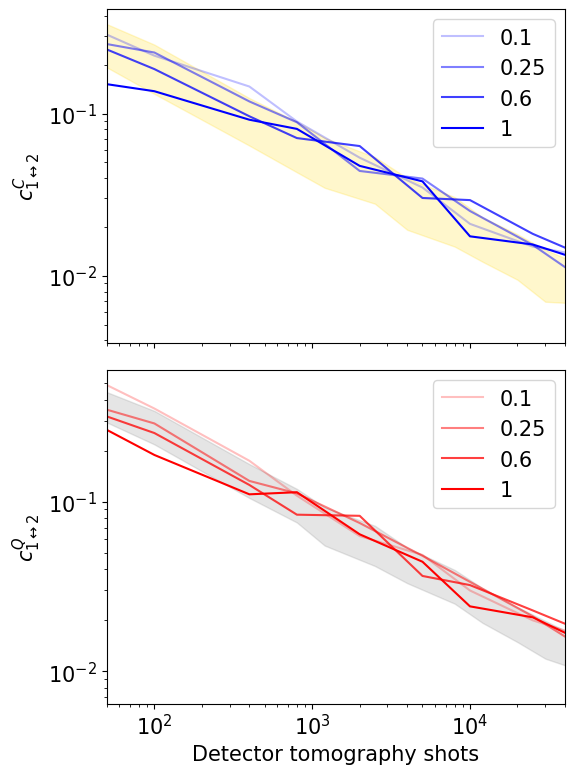

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)



# Fill between for error bars (mean ± std)

classical_mean = np.mean(total_classical_array, axis=0)
classical_std = np.std(total_classical_array, axis=0)
ax1.fill_between(dt_shot_list_C, classical_mean - classical_std, classical_mean + classical_std, color="gold", alpha=0.2)

ax1.plot(dt_shot_list, np.mean([data["classical_corr_01s_0.1"], data["classical_corr_10s_0.1"]], axis=0), color = 'blue', alpha=0.25, label = '0.1')
ax1.plot(dt_shot_list, np.mean([data["classical_corr_01s_0.25"], data["classical_corr_10s_0.25"]], axis=0), color = 'blue', alpha=0.5, label = '0.25')

ax1.plot(dt_shot_list, np.mean([data["classical_corr_01s_0.6"], data["classical_corr_10s_0.6"]], axis=0), color = 'blue', alpha=0.75, label = '0.6')
ax1.plot(dt_shot_list, np.mean([data["classical_corr_01s_1"], data["classical_corr_10s_1"]], axis=0), color = 'blue', alpha=1, label = '1')

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.legend()
ax1.set_ylabel(r'$c^{C}_{1\leftrightarrow 2}$')
#ax1.set_title("classical corrs")




quantum_mean = np.mean(total_quantum_array, axis=0)
quantum_std = np.std(total_quantum_array, axis=0)
ax2.fill_between(dt_shot_list_C, quantum_mean - quantum_std, quantum_mean + quantum_std, color="gray", alpha=0.2)


ax2.plot(dt_shot_list, np.mean([data["quantum_corr_01s_0.1"], data["quantum_corr_10s_0.1"]], axis=0), color = 'red',alpha=0.25, label = '0.1')
ax2.plot(dt_shot_list, np.mean([data["quantum_corr_01s_0.25"], data["quantum_corr_10s_0.25"]], axis=0), color = 'red',alpha=0.5, label = '0.25')
ax2.plot(dt_shot_list, np.mean([data["quantum_corr_01s_0.6"], data["quantum_corr_10s_0.6"]], axis=0), color = 'red',alpha=0.75, label = '0.6')
ax2.plot(dt_shot_list, np.mean([data["quantum_corr_01s_1"], data["quantum_corr_10s_1"]], axis=0), color = 'red',alpha=1, label = '1')
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel(r'$c^{Q}_{1\leftrightarrow 2}$')
ax2.set_xlabel("Detector tomography shots")
ax2.set_xlim(dt_shot_list[0], dt_shot_list[-1])
ax2.legend()
#ax2.set_title("quantum corrs")
fig.tight_layout()
fig.savefig("fig_8.pdf", bbox_inches="tight")

# Fig 9

In [ ]:
import os
import numpy as np

# Target directory
fig9a_dir = "fig 9/fig 9/A/"

# Dictionary to store loaded arrays
dataA = {}

# Load all .npy files
for file in os.listdir(fig9a_dir):
    if file.endswith('.npy'):
        key = file[:-4]  # Remove '.npy'
        file_path = os.path.join(fig9a_dir, file)
        try:
            arr = np.load(file_path, allow_pickle=True)
            # Ensure we store clean ndarray (not object array)
            if isinstance(arr, np.ndarray) and arr.dtype == object:
                try:
                    arr = np.stack(arr)
                except Exception:
                    arr = np.array(arr)
            dataA[key] = arr
        except Exception as e:
            print(f"Failed to load {file}: {e}")


import os
import numpy as np

# Target directory
fig9a_dir = "fig 9/fig 9/C/"

# Dictionary to store loaded arrays
dataC = {}

# Load all .npy files
for file in os.listdir(fig9a_dir):
    if file.endswith('.npy'):
        key = file[:-4]  # Remove '.npy'
        file_path = os.path.join(fig9a_dir, file)
        try:
            arr = np.load(file_path, allow_pickle=True)
            # Ensure we store clean ndarray (not object array)
            if isinstance(arr, np.ndarray) and arr.dtype == object:
                try:
                    arr = np.stack(arr)
                except Exception:
                    arr = np.array(arr)
            dataC[key] = arr
        except Exception as e:
            print(f"Failed to load {file}: {e}")

dt_shot_list_C = [50, 100, 400, 800, 1200, 2500, 4000, 8000, 12000, 20000, 30000, 50000, 70000]

dt_shot_list_A = [50, 100, 400, 800, 1200, 3000, 5000, 10000, 20000, 30000, 50000, 70000]

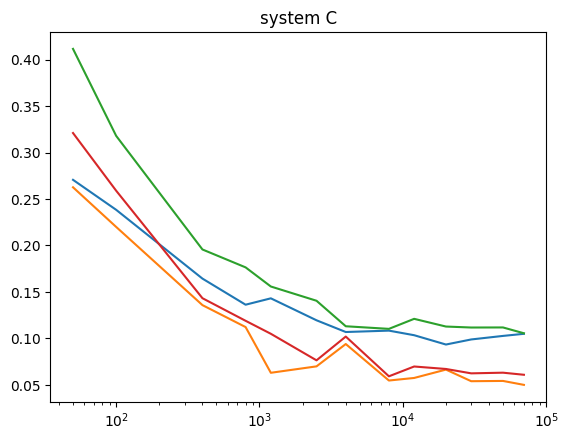

Text(0.5, 1.0, 'system A')

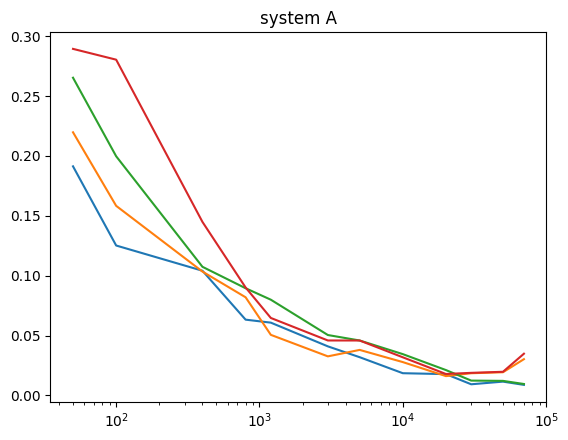

In [ ]:
plt.plot(dt_shot_list_C, dataC["classical_corr_01s"])
plt.plot(dt_shot_list_C, dataC["classical_corr_10s"])
plt.plot(dt_shot_list_C, dataC["quantum_corr_01s"])
plt.plot(dt_shot_list_C, dataC["quantum_corr_10s"])

plt.xscale("log")
plt.title("system C")
plt.show()

plt.plot(dt_shot_list_A, dataA["classical_corr_01s"])
plt.plot(dt_shot_list_A, dataA["classical_corr_10s"])
plt.plot(dt_shot_list_A, dataA["quantum_corr_01s"])
plt.plot(dt_shot_list_A, dataA["quantum_corr_10s"])

plt.xscale("log")
plt.title("system A")

## Fig 10

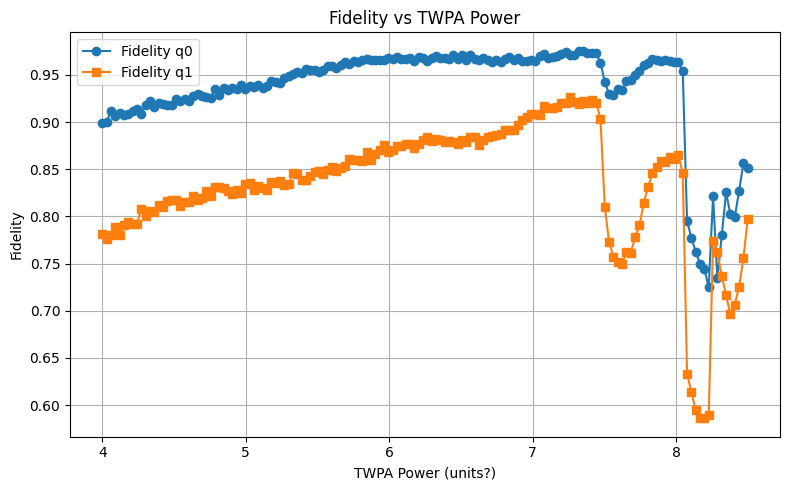

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the folder path
folder_path = os.path.join("twpa data", "much twpa data")

# Load the .npy files
powers = np.load(os.path.join(folder_path, "app q0q1 twpa powers.npy"))
fids0 = np.load(os.path.join(folder_path, "app q0q1 twpa fids0.npy"))
fids1 = np.load(os.path.join(folder_path, "app q0q1 twpa fids1.npy"))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(powers, fids0, label="Fidelity q0", marker='o')
plt.plot(powers, fids1, label="Fidelity q1", marker='s')
plt.xlabel("TWPA Power (units?)")
plt.ylabel("Fidelity")
plt.title("Fidelity vs TWPA Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Fig 11

In [ ]:
coh_err_xx_mixed_ac = np.load("Fig 11/povm drift v2/coherent_errors_xx_rotated_ac off then on.npy")
coh_err_xx_pure_ac = np.load("Fig 11/povm drift v2/coherent_errors_xx_rotated_ac on.npy")

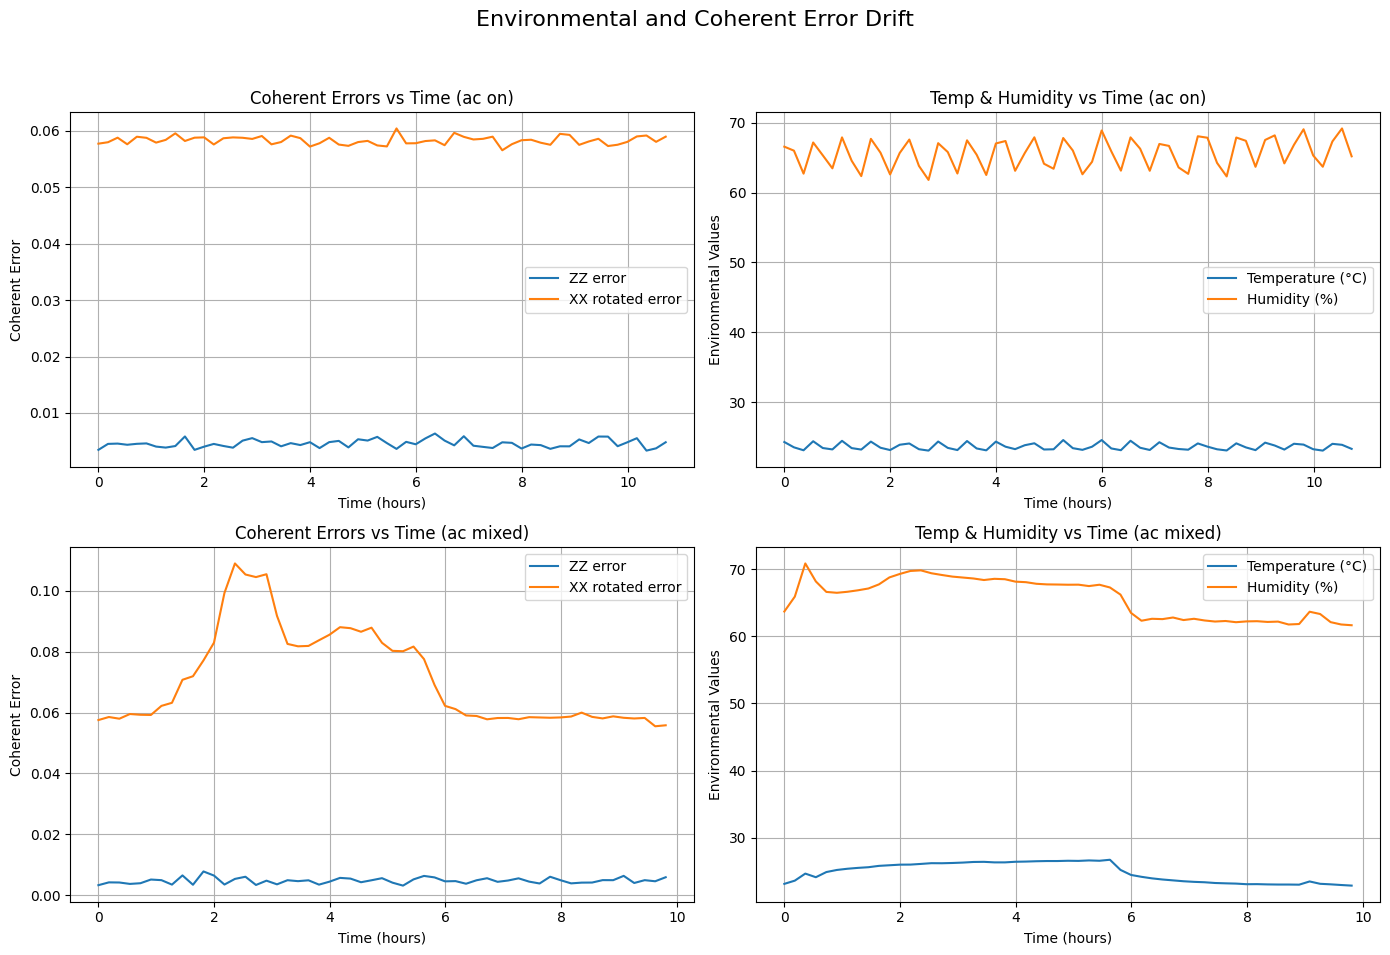

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths
base_path = "Fig 11/povm drift v2"
folders = ["ac on", "ac mixed"]

# Set up figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Environmental and Coherent Error Drift', fontsize=16)

for idx, folder in enumerate(folders):
    path = os.path.join(base_path, folder)
    
    # Load data
    start_times = np.load(os.path.join(path, "start_times_list.npy"))
    temperature = np.load(os.path.join(path, "temperature_list.npy"))
    humidity = np.load(os.path.join(path, "humidity_list.npy"))
    coherent_zz = np.load(os.path.join(path, "coherent_errors_zz.npy"))
    coherent_xx = np.load(os.path.join(path, "coherent_errors_xx_rotated.npy"))

    # Time axis in hours
    time_axis = (start_times - start_times[0]) / 3600  # seconds to hours

    # Subplot: Coherent errors vs time
    ax_err = axes[idx, 0]
    ax_err.plot(time_axis, coherent_zz, label='ZZ error')
    ax_err.plot(time_axis, coherent_xx, label='XX rotated error')
    ax_err.set_title(f'Coherent Errors vs Time ({folder})')
    ax_err.set_xlabel('Time (hours)')
    ax_err.set_ylabel('Coherent Error')
    ax_err.legend()
    ax_err.grid(True)

    # Subplot: Temperature & Humidity vs time
    ax_env = axes[idx, 1]
    ax_env.plot(time_axis, temperature, label='Temperature (°C)')
    ax_env.plot(time_axis, humidity, label='Humidity (%)')
    ax_env.set_title(f'Temp & Humidity vs Time ({folder})')
    ax_env.set_xlabel('Time (hours)')
    ax_env.set_ylabel('Environmental Values')
    ax_env.legend()
    ax_env.grid(True)

# Layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for suptitle
plt.show()


# Fig 12

In [ ]:

# Base directory
fig12_dir = Path("fig 12")

# File paths
qst_results_path = fig12_dir / "QST_results.npy"
qst_settings_path = fig12_dir / "QST_settings.npy"
dt_settings_path = fig12_dir / "DT_settings.npy"

# Dictionary to hold loaded data
data = {}

# Helper function to load with feedback
def load_npy(path, name):
    if path.exists():
        try:
            arr = np.load(path, allow_pickle=True)
            data[name] = arr
            print(f"Loaded {name} successfully.")
        except Exception as e:
            print(f"Failed to load {name}: {e}")
    else:
        print(f"{name} not found at {path}")

# Load each file
load_npy(qst_results_path, "QST_results")
load_npy(qst_settings_path, "QST_settings")
load_npy(dt_settings_path, "DT_settings")

# If they're dictionaries or objects, you can extract them like:
try:
    qst_results = data["QST_results"].item()
    qst_settings = data["QST_settings"].item()
    dt_settings = data["DT_settings"].item()
except Exception as e:
    print(f"Could not convert to dicts/objects: {e}")


Loaded QST_results successfully.
Failed to load QST_settings: No module named 'EMQST_lib'
Failed to load DT_settings: No module named 'EMQST_lib'
Could not convert to dicts/objects: can only convert an array of size 1 to a Python scalar


I dont have EMQST installed and cannot install it, but now you should have the data to plot the density matrix that is reconstructed.

Here is the density matrix we wanted to reconstruct (and then just plot the differences of the reconstructed and theoretical one to get to the plot 13 in the paper)

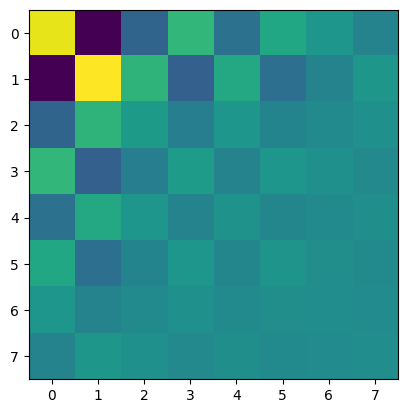

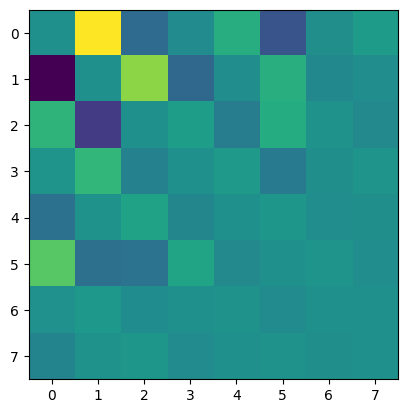

In [100]:
dm_theory = np.load("fig 12/true 3q state.npy")[0]
plt.imshow(np.real(dm_theory))
plt.show()
plt.imshow(np.imag(dm_theory))